<a href="https://colab.research.google.com/github/onuralpArsln/InfoBits/blob/main/MonteCarloSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreReq
This cell will be used to prepare your env

In [5]:
!curl -o NACA0012-radians.txt https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/airfoils/NACA0012-radians.txt
!curl -o Cesaroni_M1670.eng https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/motors/cesaroni/Cesaroni_M1670.eng
!curl -o powerOffDragCurve.csv https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/rockets/calisto/powerOffDragCurve.csv
!curl -o powerOnDragCurve.csv https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/rockets/calisto/powerOnDragCurve.csv
!pip install rocketpy -q
from rocketpy import Environment, SolidMotor, Rocket, Flight, MonteCarlo, Function
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticSolidMotor,
    StochasticRocket,
    StochasticFlight,
    StochasticNoseCone,
    StochasticTail,
    StochasticTrapezoidalFins,
    StochasticParachute,
    StochasticRailButtons,
)
from rocketpy import Environment, SolidMotor, Rocket, Flight
import datetime

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline


# Standard Simulation

In [13]:
# Environment
env = Environment(latitude=39.389700, longitude=-8.288964, elevation=113)
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))
env.set_atmospheric_model(type="Ensemble", file="GEFS")

# Motor
motor = SolidMotor(
    thrust_source="Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
print(f"Total Impulse of the Solid Motor: {motor.total_impulse} Ns")

# Rocket
rocket = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="powerOffDragCurve.csv",
    power_on_drag="powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = rocket.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

rocket.add_motor(motor, position=-1.255)

nose_cone = rocket.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = rocket.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("NACA0012-radians.txt", "radians"),
)

tail = rocket.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)
Main = rocket.add_parachute(
    "Main",
    cd_s=10.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = rocket.add_parachute(
    "Drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

# Flight
test_flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=5,
    inclination=84,
    heading=133,
)

Total Impulse of the Solid Motor: 6026.35 Ns


To see results

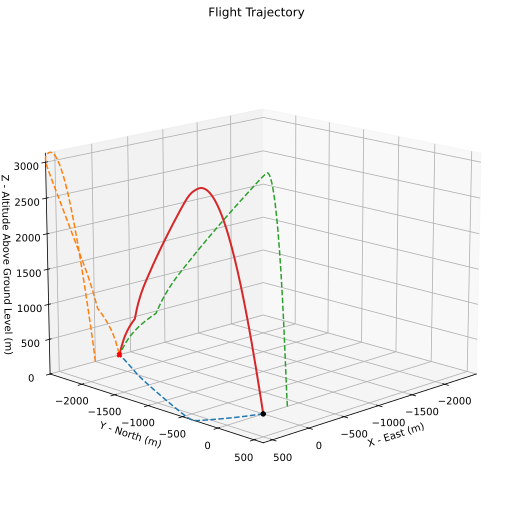

In [14]:
test_flight.plots.trajectory_3d()

#Step 2: Stochastic Objects

In [15]:
stochastic_env = StochasticEnvironment(
    environment=env,
    ensemble_member=list(range(env.num_ensemble_members)),
)

stochastic_env.visualize_attributes()

Reporting the attributes of the `StochasticEnvironment` object:

Constant Attributes:
	datum                    SIRGAS2000
	elevation                113
	gravity                  Function from R1 to R1 : (height (m)) → (gravity (m/s²))
	latitude                 39.3897
	longitude                -8.288964
	timezone                 UTC

Stochastic Attributes:
	wind_velocity_x_factor   1.00000 ± 0.00000 (normal)
	wind_velocity_y_factor   1.00000 ± 0.00000 (normal)

Stochastic Attributes with choice of values:
	ensemble_member [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [16]:
wind_speed_at_1000m = []
for i in range(5):
    rnd_env = stochastic_env.create_object()
    wind_speed_at_1000m.append(rnd_env.wind_velocity_x(1000))

print(wind_speed_at_1000m)

[-2.459096921195436, -1.3844945556231627, -3.0443388787332006, -5.0810240245940825, -2.2966979823343787]


In [17]:
stochastic_motor = StochasticSolidMotor(
    solid_motor=motor,
    burn_start_time=(0, 0.1, "binomial"),
    grains_center_of_mass_position=0.001,
    grain_density=50,
    grain_separation=1 / 1000,
    grain_initial_height=1 / 1000,
    grain_initial_inner_radius=0.375 / 1000,
    grain_outer_radius=0.375 / 1000,
    total_impulse=(6500, 1000),
    throat_radius=0.5 / 1000,
    nozzle_radius=0.5 / 1000,
    nozzle_position=0.001,
)
stochastic_motor.visualize_attributes()

Reporting the attributes of the `StochasticSolidMotor` object:

Constant Attributes:
	burn_out_time                    3.9
	center_of_dry_mass_position      0.317
	coordinate_system_orientation    nozzle_to_combustion_chamber
	dry_I_11                         0.125
	dry_I_12                         0
	dry_I_13                         0
	dry_I_22                         0.125
	dry_I_23                         0
	dry_I_33                         0.002
	dry_mass                         1.815
	grain_number                     5
	interpolate                      linear
	thrust_source                    [[0, 0], [0.055, 100.0], [0.092, 1500.0], [0.1, 2000.0], [0.15, 2200.0], [0.2, 1800.0], [0.5, 1950.0], [1.0, 2034.0], [1.5, 2000.0], [2.0, 1900.0], [2.5, 1760.0], [2.9, 1700.0], [3.0, 1650.0], [3.3, 530.0], [3.4, 350.0], [3.9, 0.0]]

Stochastic Attributes:
	burn_start_time                  0.00000 ± 0.10000 (binomial)
	grain_density                    1815.00000 ± 50.00000 (normal)
	grain_ini

In [18]:
total_impulse = []
for i in range(5):
    rnd_motor = stochastic_motor.create_object()
    total_impulse.append(rnd_motor.total_impulse)

print(total_impulse)

[6774.652573425548, 7432.114491888144, 6190.7830648616655, 6434.875100134554, 8036.657992419263]


In [19]:
stochastic_rocket = StochasticRocket(
    rocket=rocket,
    radius=0.0127 / 2000,
    mass=(15.426, 0.5, "normal"),
    inertia_11=(6.321, 0),
    inertia_22=0.01,
    inertia_33=0.01,
    center_of_mass_without_motor=0,
)
stochastic_rocket.visualize_attributes()


Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_12_without_motor              0
	I_13_without_motor              0
	I_23_without_motor              0
	coordinate_system_orientation   tail_to_nose
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)

Stochastic Attributes:
	I_11_without_motor              6.32100 ± 0.00000 (normal)
	I_22_without_motor              6.32100 ± 0.01000 (normal)
	I_33_without_motor              0.03400 ± 0.01000 (normal)
	center_of_mass_without_motor    0.00000 ± 0.00000 (normal)
	mass                            15.42600 ± 0.50000 (normal)
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)
	radius                          0.06350 ± 0.00001 (normal)


In [20]:
stochastic_nose_cone = StochasticNoseCone(
    nosecone=nose_cone,
    length=0.001,
)

stochastic_fin_set = StochasticTrapezoidalFins(
    trapezoidal_fins=fin_set,
    root_chord=0.0005,
    tip_chord=0.0005,
    span=0.0005,
)

stochastic_tail = StochasticTail(
    tail=tail,
    top_radius=0.001,
    bottom_radius=0.001,
    length=0.001,
)

stochastic_rail_buttons = StochasticRailButtons(
    rail_buttons=rail_buttons, buttons_distance=0.001
)

stochastic_main = StochasticParachute(
    parachute=Main,
    cd_s=0.1,
    lag=0.1,
)

stochastic_drogue = StochasticParachute(
    parachute=Drogue,
    cd_s=0.07,
    lag=0.2,
)

In [21]:
stochastic_rocket.add_motor(stochastic_motor, position=0.001)
stochastic_rocket.add_nose(stochastic_nose_cone, position=(1.134, 0.001))
stochastic_rocket.add_trapezoidal_fins(stochastic_fin_set, position=(0.001, "normal"))
stochastic_rocket.add_tail(stochastic_tail)
stochastic_rocket.set_rail_buttons(
    stochastic_rail_buttons, lower_button_position=(0.001, "normal")
)
stochastic_rocket.add_parachute(stochastic_main)
stochastic_rocket.add_parachute(stochastic_drogue)

In [22]:
stochastic_rocket.visualize_attributes()

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_12_without_motor              0
	I_13_without_motor              0
	I_23_without_motor              0
	coordinate_system_orientation   tail_to_nose
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)

Stochastic Attributes:
	I_11_without_motor              6.32100 ± 0.00000 (normal)
	I_22_without_motor              6.32100 ± 0.01000 (normal)
	I_33_without_motor              0.03400 ± 0.01000 (normal)
	center_of_mass_without_motor    0.00000 ± 0.00000 (normal)
	mass                            15.42600 ± 0.50000 (normal)
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)
	radius                          0.06350 ± 0.00001 (normal)


In [23]:
stochastic_flight = StochasticFlight(
    flight=test_flight,
    inclination=(84.7, 1),  # mean= 84.7, std=1
    heading=(53, 2),  # mean= 53, std=2
)
stochastic_flight.visualize_attributes()

Reporting the attributes of the `StochasticFlight` object:

Constant Attributes:
	rail_length           5

Stochastic Attributes:
	heading               53.00000 ± 2.00000 (normal)
	inclination           84.70000 ± 1.00000 (normal)


In [27]:
test_dispersion = MonteCarlo(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example",
    environment=stochastic_env,
    rocket=stochastic_rocket,
    flight=stochastic_flight,
)

In [31]:
!mkdir monte_carlo_analysis_outputs
!touch monte_carlo_analysis_outputs/monte_carlo_class_example.inputs.txt

In [34]:
test_dispersion.simulate(
    number_of_simulations=5, append=False, include_function_data=False
)

Completed 10 iterations. Total CPU time: 17.3 s. Total wall time: 17.6 s
Saving results.     
Results saved to monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt


In [33]:
test_dispersion.prints.all()

Monte Carlo Simulation by RocketPy
Data Source:  monte_carlo_analysis_outputs/monte_carlo_class_example
Number of simulations:  38
Results: 

                Parameter            Mean          Median       Std. Dev.    95% PI Lower    95% PI Upper
--------------------------------------------------------------------------------------------------------------
                 x_impact        -313.734        -271.042         241.444        -889.692          16.384
 initial_stability_margin           2.589           2.567           0.080           2.454           2.744
         out_of_rail_time           0.358           0.360           0.021           0.327           0.395
          max_mach_number           0.864           0.848           0.111           0.681           1.047
                   apogee        3281.200        3284.497         497.149        2425.274        4065.192
                 apogee_y         606.418         592.016          94.071         409.642         784.668
     

In [35]:
test_dispersion.prints.all()

Monte Carlo Simulation by RocketPy
Data Source:  monte_carlo_analysis_outputs/monte_carlo_class_example
Number of simulations:  10
Results: 

                Parameter            Mean          Median       Std. Dev.    95% PI Lower    95% PI Upper
--------------------------------------------------------------------------------------------------------------
                 x_impact        -312.245        -229.470         227.813        -649.580          38.079
 initial_stability_margin           2.616           2.601           0.064           2.540           2.729
         out_of_rail_time           0.349           0.356           0.023           0.316           0.374
          max_mach_number           0.918           0.867           0.137           0.778           1.118
                   apogee        3506.083        3345.463         545.708        2901.765        4336.691
                 apogee_y         641.857         650.988         115.910         492.793         846.485
     

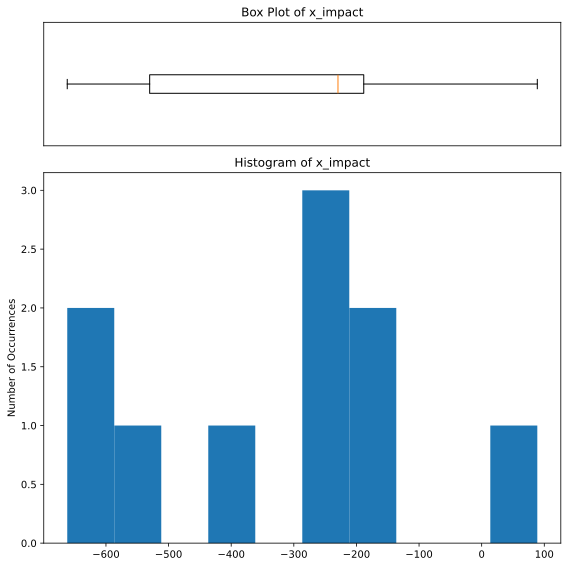

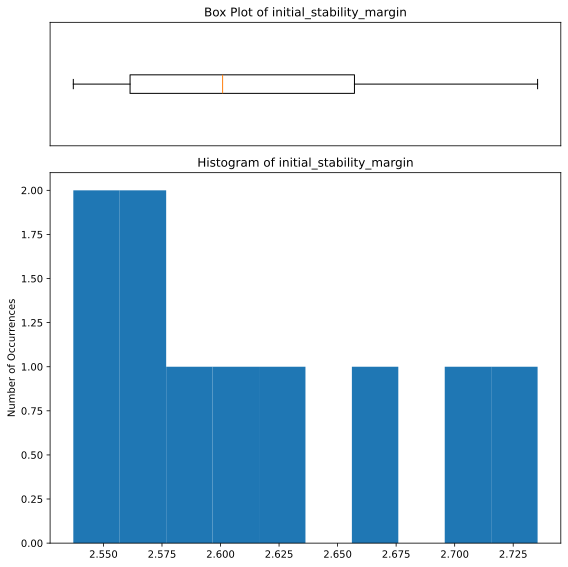

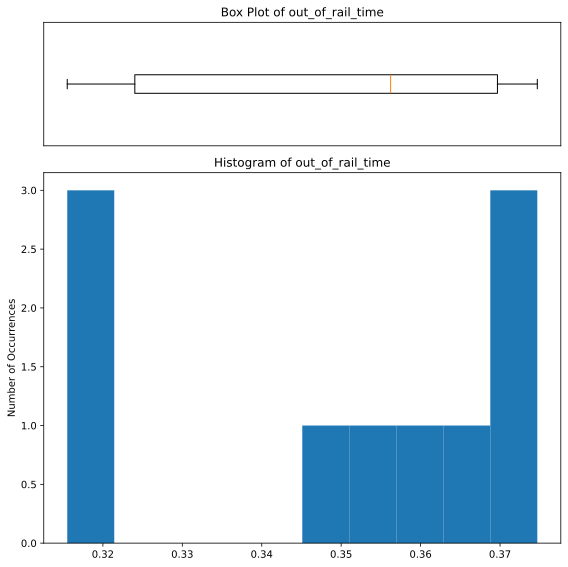

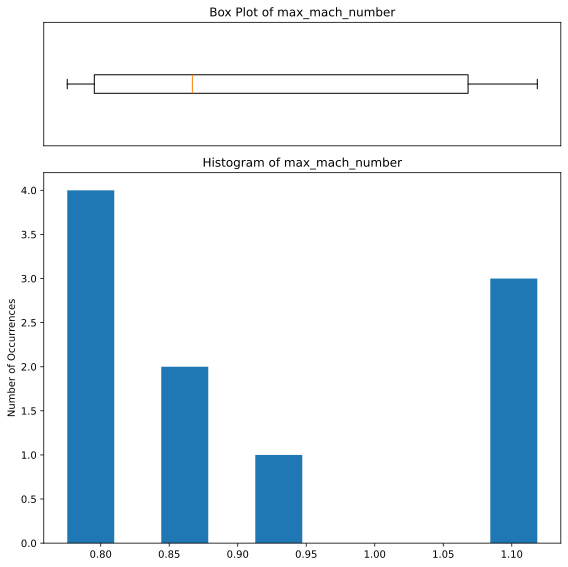

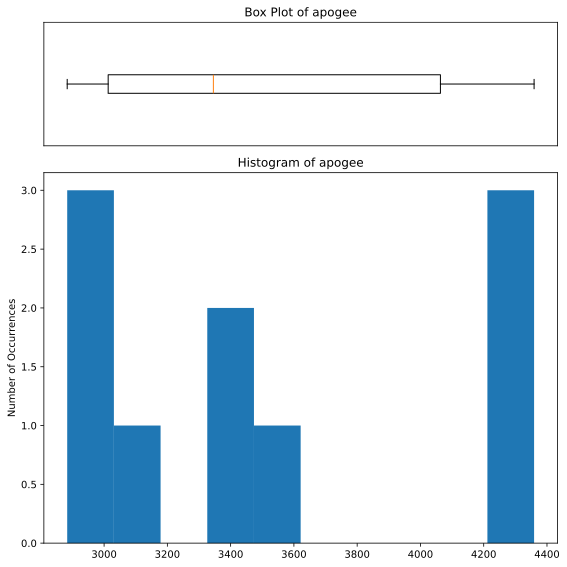

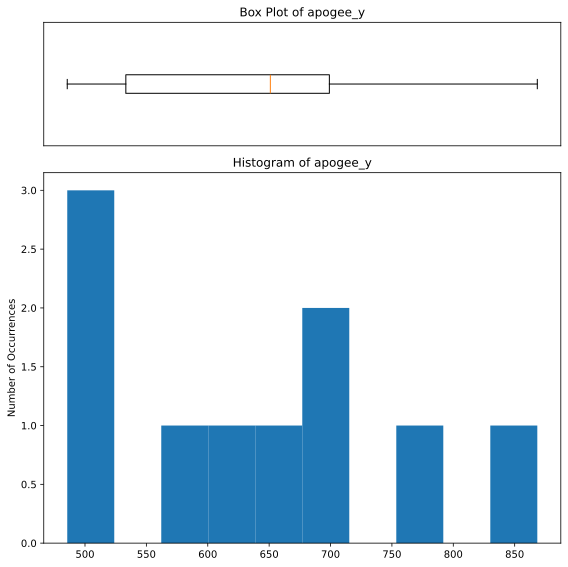

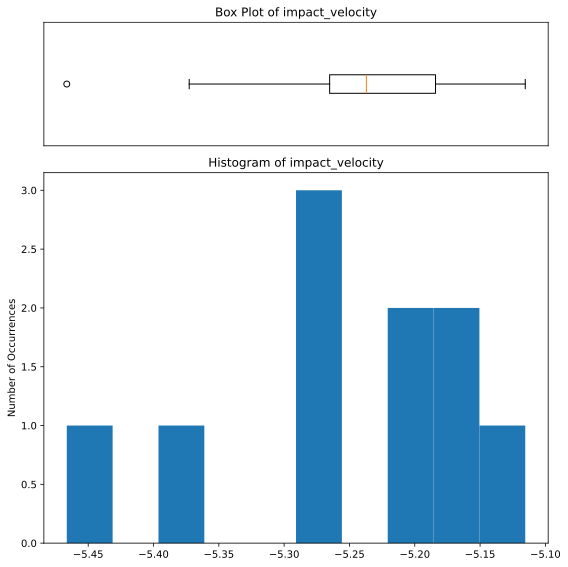

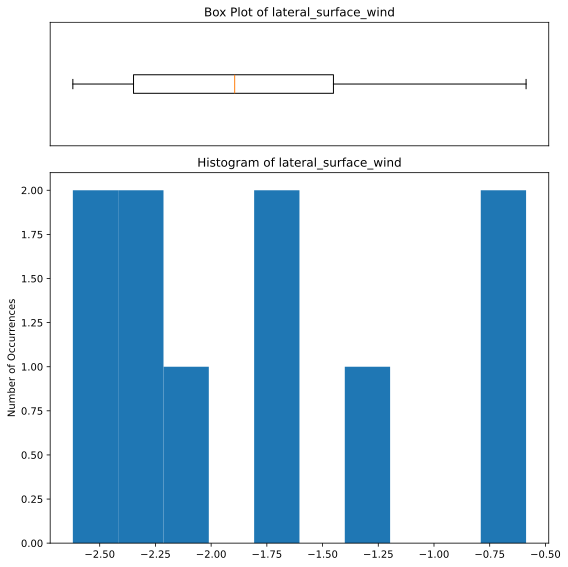

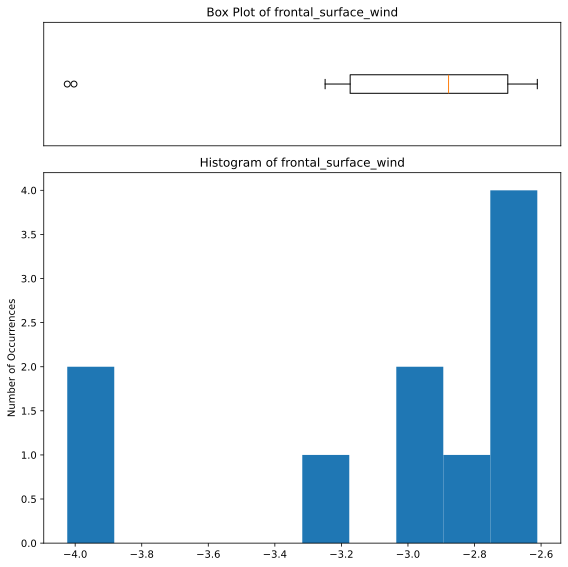

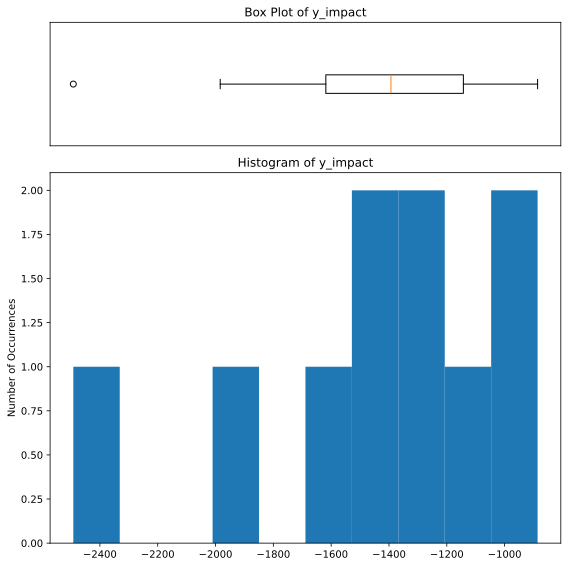

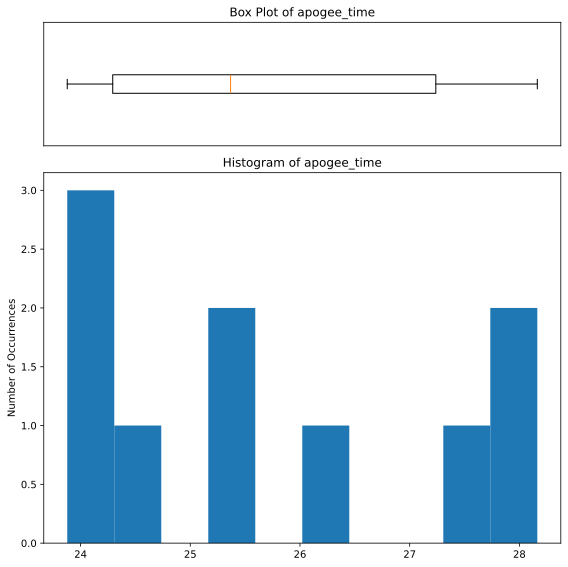

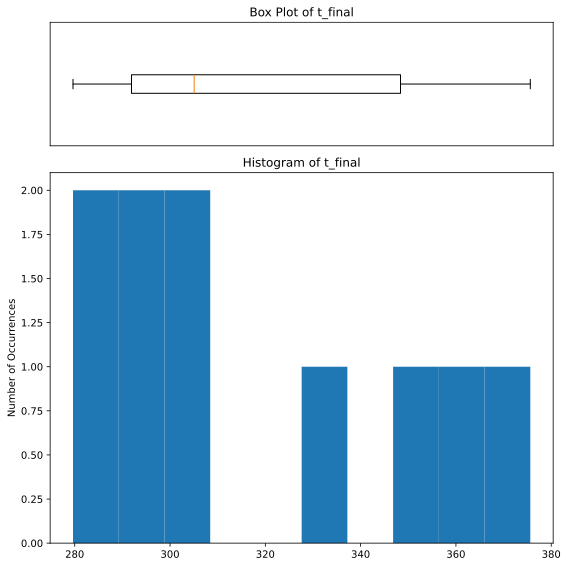

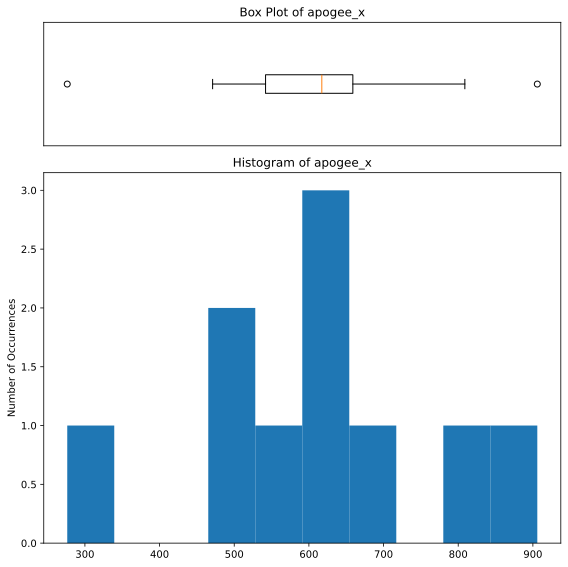

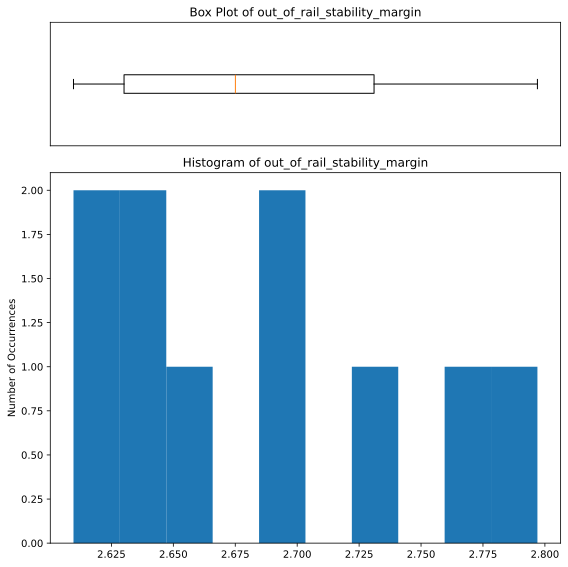

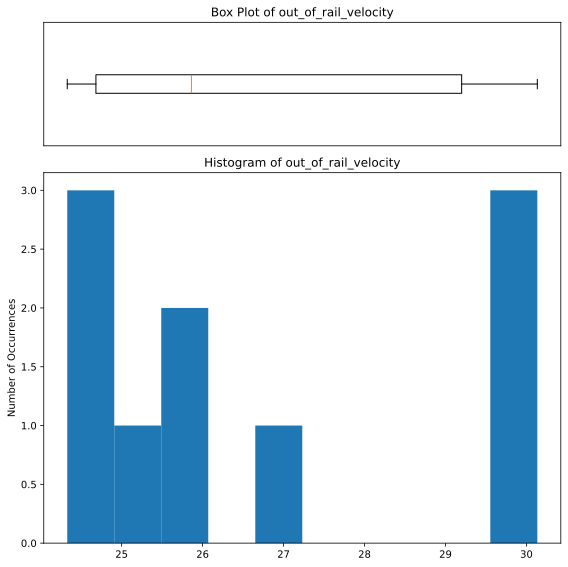

In [36]:
test_dispersion.plots.all()

In [ ]:
test_dispersion.export_ellipses_to_kml(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example.kml",
    origin_lat=env.latitude,
    origin_lon=env.longitude,
    type="impact",
)